# Second models
We are now trying to add the categorical features. There is no ordinal feature in the dataset, we will the use the One-Hot Encoding method to deal with it. Here is the basis on how the data are transformed : 
- Deleting the columns ['CurrencyCode', 'CountryCode'] because it only has one value and won't have influence on the target. 
- Set the index to the id of the TransactionId column
- Adding some data related to the date. We created the columns from the TransactionStartTime : the day, the hour, the day of the week, and the week of the month. After evaluation of the MI, we considered that the seconds and minutes of the transaction were did not have a lot of influence of the target and will not be considered to not add too much new features. 
- Drop the column datetime because the models don't takes this format
- Create the One-Hot-Encoding on the low cardinality columns : ['ProviderId', 'ProductCategory', 'ChannelId', 'PricingStrategy']
- Transforming the string columns into int

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
import datetime as dt
from math import ceil, sqrt
from Utils import *
pd.set_option('max_colwidth', None)
from EvaluationMetric import *
from xgboost import XGBClassifier

## 1. With OHE and without TransactionStartTime column

In [21]:
# data cleaning
#Data loading
def_feature = pd.read_csv("input/Xente_Variable_Definitions.csv")
raw_data = pd.read_csv("input/training.csv")
X_test = pd.read_csv("input/test.csv")
sample_submission = pd.read_csv("input/sample_submission.csv")

#attribut initialization
cols_unique_value = [] #Will be droped
for col in raw_data.columns : 
    if len(raw_data[col].unique()) == 1 :
        cols_unique_value.append(col)
        
medium_cardianlity_cols = ["ProductId"]

#Data transformation
raw_data['TransactionStartTime'] = pd.to_datetime(raw_data['TransactionStartTime'])
X_test['TransactionStartTime'] = pd.to_datetime(X_test['TransactionStartTime'])

#Data cleaning
data = raw_data.copy()
data = data.dropna(axis=0) #Drop observations/rows with missing values
X_test=X_test.dropna(axis=0)
data.drop(cols_unique_value, axis=1, inplace=True)
X_test.drop(cols_unique_value, axis=1, inplace=True)

#Prepare index for the submission
index_val = list(X_test.TransactionId.values.tolist())

#Set the df index to the Transction Id
data = transactioId_to_index(data)
X_test = transactioId_to_index(X_test)

#Adding data
data = adding_date_col(data, 'TransactionStartTime')
X_test = adding_date_col(X_test, 'TransactionStartTime')


# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in data.columns if data[cname].nunique() < 15 and 
                        data[cname].dtype == "object"]
low_cardinality_cols.append('PricingStrategy')

#transform columns BatchId_54 to number

l_col_str = ["BatchId", "AccountId", "SubscriptionId", "CustomerId", "ProviderId", "ProductId", "ChannelId"]
for col in l_col_str:
    data[['dc', 'new_col']] = data[col].str.split("_", expand = True)
    data.drop(['dc',col], inplace=True, axis=1)
    data.rename(columns={"new_col": col}, inplace=True)
    data[col] = data[col].astype('int')
    X_test[['dc', 'new_col']] = X_test[col].str.split("_", expand = True)
    X_test.drop(['dc',col], inplace=True, axis=1)
    X_test.rename(columns={"new_col": col}, inplace=True)
    X_test[col] = X_test[col].astype('int')
data['PricingStrategy'] = data['PricingStrategy'].astype('int')
X_test['PricingStrategy'] = X_test['PricingStrategy'].astype('int')
data['Value'] = data['Value'].astype('float')
X_test['Value'] = X_test['Value'].astype('float')

X_test['PricingStrategy'] = X_test['PricingStrategy'].astype('str')
data['PricingStrategy'] = data['PricingStrategy'].astype('str')

#Data splitting
y = data.FraudResult #The target label
X = data.copy()
X.drop(['FraudResult'], axis=1, inplace=True) #Only the features data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

#Other data
#Information on columns on raw_data
## P-e transformer ca en une fonction ? 
info = pd.DataFrame(data = raw_data.dtypes)
info.reset_index(inplace=True)
info.rename({'index':'Column Name', 0: 'Dtype'}, axis=1, inplace=True)
describe = def_feature.copy()
describe = describe.merge(info)
unique_val = []
for col in list(describe["Column Name"]) : 
    unique_val.append(len(raw_data[col].unique()))
describe["unique"]=unique_val
describe = added_column(describe)
cat_cols = [col for col in train_X.columns if train_X[col].dtype == "object"]#liste of obejct columns
cat_cols.append("PricingStrategy")#pcq mm si c'est un chiffre il faut le considérer comme une catégorie

#print(describe)


#low_cardinality_cols=["ProviderId", "ProductCategory", "ChannelId", "PricingStrategy"] 
#train_X[low_cardinality_cols] = train_X[low_cardinality_cols].astype(str) 
#val_X[low_cardinality_cols] = val_X[low_cardinality_cols].astype(str) 

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_X[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(val_X[low_cardinality_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[low_cardinality_cols]))
# One-hot encoding removed index; put it back
OH_cols_train.index = train_X.index
OH_cols_valid.index = val_X.index
OH_cols_test.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
#print(f'Col avant : {train_X.columns}')
num_X_train = train_X.drop(low_cardinality_cols, axis=1)
num_X_valid = val_X.drop(low_cardinality_cols, axis=1)
num_X_test = X_test.drop(low_cardinality_cols, axis=1)
#print(f'col num : {num_X_train.columns}')

OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
#print(f'col apres concat : {OH_X_train.columns}')
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

# Problème de string
OH_X_train.drop(['TransactionStartTime'], inplace=True, axis=1)
OH_X_valid.drop(['TransactionStartTime'], inplace=True, axis=1)
OH_X_test.drop(['TransactionStartTime'], inplace=True, axis=1)
OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)
OH_X_test.columns = OH_X_test.columns.astype(str)

train_X = OH_X_train
val_X = OH_X_valid

In [19]:
describe

,Column Name,Definition,Dtype,unique
0,TransactionId,Unique �transaction identifier on platform,object,95662.0
1,BatchId,Unique number assigned to a batch of transactions for processing,object,94809.0
2,AccountId,Unique number identifying the customer on platform,object,3633.0
3,SubscriptionId,Unique number identifying the customer subscription,object,3627.0
4,CustomerId,Unique identifier attached to Account,object,3742.0
5,CurrencyCode,Country currency,object,1.0
6,CountryCode,Numerical geographical code of country,int64,1.0
7,ProviderId,Source provider of Item �bought.,object,6.0
8,ProductId,Item name being bought.,object,23.0
9,ProductCategory,ProductIds are organized into these broader product categories.,object,9.0


In [3]:
train_X.head()

,Amount,Value,Day,Hour,week_day,weeks,BatchId,AccountId,SubscriptionId,CustomerId,...,13,14,15,16,17,18,19,20,21,22
TransactionId,,,,,,,,,,,,,,,,,,,,,
82059,2500.0,2500.0,28,10,4,4,48408,2946,3991,3371,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
115282,1000.0,1000.0,9,7,2,2,5122,4468,3787,4928,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
36103,2000.0,2000.0,15,15,5,2,117608,3750,3024,4193,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5655,-1000.0,1000.0,24,8,5,4,75137,4841,3829,4371,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
87110,-5000.0,5000.0,7,6,4,1,84248,4841,3829,2710,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [4]:
train_X.columns

Index(['Amount', 'Value', 'Day', 'Hour', 'week_day', 'weeks', 'BatchId',
       'AccountId', 'SubscriptionId', 'CustomerId', 'ProductId', '0', '1', '2',
       '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15',
       '16', '17', '18', '19', '20', '21', '22'],
      dtype='object')

## Try on models
### Decision Tree Classifier

In [22]:
model1 = DecisionTreeClassifier(random_state=1)
model1.fit(train_X, train_y)
model_pred = model1.predict(val_X)
model_test = model1.predict(OH_X_test)
df1 = getscoreforcsv(index_val, model_test)
report1 = listmetrics(val_y, model_pred, "Decision Tree Classifier", "with Categories OHE without DateTime")
report1[-2] = 0.59375
report1[-1] = 0.590909090
report1

model2 = DecisionTreeClassifier(max_leaf_nodes= 6, random_state=1)
model2.fit(train_X, train_y)
preds_val2 = model2.predict(val_X)
model_tes2t = model2.predict(OH_X_test)
description = "max_leaf_nodes : 6 + with date columns"
metrics2 = listmetrics(val_y, preds_val2, "Decision Tree Classifier", description)
metrics2[-2] = 0.666666666 #cool, s'améliore
metrics2[-1] = 0.661016949
df2 = getscoreforcsv(index_val, model_tes2t, name_file = "resultsfile6.csv")

model3 = DecisionTreeClassifier(max_leaf_nodes= 30, random_state=1)
model3.fit(train_X, train_y)
preds_val3 = model3.predict(val_X)
model_tes3t = model3.predict(OH_X_test)
description = "max_leaf_nodes : 30 + with date columns"
metrics3 = listmetrics(val_y, preds_val3, "Decision Tree Classifier", description)
metrics3[-2] = 0.655172413 #moins bien ... 
metrics3[-1] = 0.655462184
df3 = getscoreforcsv(index_val, model_tes3t, name_file = "resultsfile30.csv")

model4 = DecisionTreeClassifier(max_leaf_nodes= 5, random_state=1)
model4.fit(train_X, train_y)
preds_val4 = model4.predict(val_X)
model_test4 = model4.predict(OH_X_test)
description = "max_leaf_nodes : 5 + with date columns"
metrics4 = listmetrics(val_y, preds_val4, "Decision Tree Classifier", description)
metrics4[-2] = 0.656249999
metrics4[-1] = 0.671875
df4 = getscoreforcsv(index_val, model_test4, name_file = "resultsfile5.csv")

# ici le meilleur c'est 5 ou 6 leaf

done
done
done
done


done


In [23]:
def graphmetrics(df, rangelist):
    x = rangelist
    y1 = df.Precision.values
    y2 = df.Recall.values
    y3 = df["F1-score"].values
    y4 = df.LogLoss.values
    y5 = df.Mcc.values

    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    ax1.plot(x, y1, 'g-o', label = "Precision")
    ax1.plot(x, y2, 'b-o', label = "Recall")
    ax1.plot(x, y3, 'r-o', label = "F1-score")
    ax2.plot(x, y4, 'b-o', label = "LogLoss")
    ax1.plot(x, y5, 'y-o', label = "Mcc")
    plt.legend()


    ax2.set(xlim=(rangelist[0], rangelist[-1]), xticks=np.arange(rangelist[0], rangelist[-1], 2), ylim=(0.005, 0.04), yticks=np.arange(0.005, 0.04, 0.005), xlabel = "max_leaf_nodes")
    ax2.set_title('Log loss')
    ax1.set(xlim=(rangelist[0], rangelist[-1]), xticks=np.arange(rangelist[0], rangelist[-1], 2), ylim=(0.5, 1), yticks=np.arange(0.5, 1, 0.05), xlabel = "max_leaf_nodes", ylabel = "metrics")
    ax1.legend()

    plt.title("Metrics Decision Tree")

    plt.legend()
    plt.show()

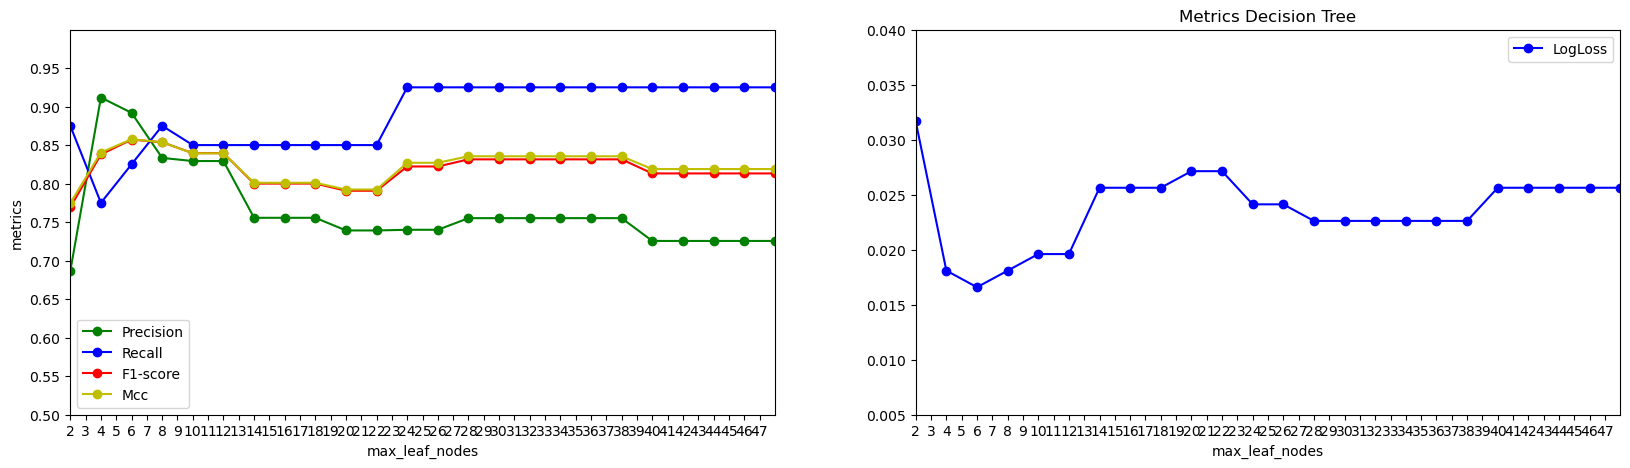

In [12]:
def test_leaf(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=1)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    description = "max_leaf_nodes : "+str(max_leaf_nodes)
    metrics = listmetrics(val_y, preds_val, "Decision Tree Classifier", description)
    return(metrics)


results = []
#for max_leaf_nodes in [3, 4, 5, 6, 7, 8, 9, 10]:
for max_leaf_nodes in np.arange(2, 50, 2, dtype=int):
    my_metrics_tree = test_leaf(max_leaf_nodes, train_X, val_X, train_y, val_y)
    results.append(my_metrics_tree)
df = listmetricsintodf(results)
df.head()

graphmetrics(df, np.arange(2, 50, 2, dtype=int))


In [13]:
df
#on va évaluer 2 point sur Zindi : le max_leaf_nodes = 30 (pallier de gauche) 
# et le max_leaf_nodes = 6 

,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc,PublicScore,PrivateScore
0,Decision Tree Classifier,max_leaf_nodes : 2,2023-04-29 17:59:07.207609,0.686275,0.875,0.769231,0.031649,0.774498,NaN,NaN
1,Decision Tree Classifier,max_leaf_nodes : 4,2023-04-29 17:59:07.309124,0.911765,0.775,0.837838,0.018085,0.840364,NaN,NaN
2,Decision Tree Classifier,max_leaf_nodes : 6,2023-04-29 17:59:07.409046,0.891892,0.825,0.857143,0.016578,0.857566,NaN,NaN
3,Decision Tree Classifier,max_leaf_nodes : 8,2023-04-29 17:59:07.510129,0.833333,0.875,0.853659,0.018085,0.853662,NaN,NaN
4,Decision Tree Classifier,max_leaf_nodes : 10,2023-04-29 17:59:07.610630,0.829268,0.850,0.839506,0.019592,0.839298,NaN,NaN
5,Decision Tree Classifier,max_leaf_nodes : 12,2023-04-29 17:59:07.711151,0.829268,0.850,0.839506,0.019592,0.839298,NaN,NaN
6,Decision Tree Classifier,max_leaf_nodes : 14,2023-04-29 17:59:07.811151,0.755556,0.850,0.800000,0.025621,0.801037,NaN,NaN
7,Decision Tree Classifier,max_leaf_nodes : 16,2023-04-29 17:59:07.911152,0.755556,0.850,0.800000,0.025621,0.801037,NaN,NaN
8,Decision Tree Classifier,max_leaf_nodes : 18,2023-04-29 17:59:08.058602,0.755556,0.850,0.800000,0.025621,0.801037,NaN,NaN
9,Decision Tree Classifier,max_leaf_nodes : 20,2023-04-29 17:59:08.199127,0.739130,0.850,0.790698,0.027128,0.792260,NaN,NaN


In [9]:
report

['Decision Tree Classifier',
 'with Categories OHE without DateTime',
 Timestamp('2023-04-29 17:51:59.483708'),
 0.7307692307692307,
 0.95,
 0.8260869565217392,
 0.024113499507688565,
 0.8329001768467879,
 0.59375,
 0.59090909]

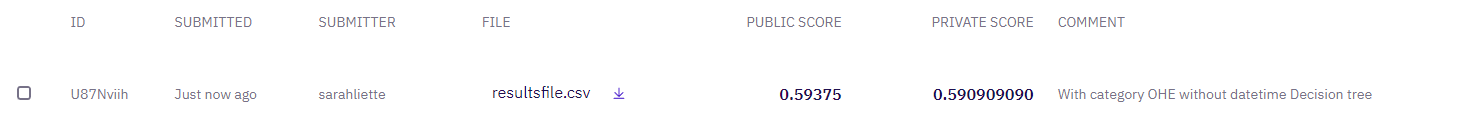
This one is worst with category than without

## 2. With OHE and without TransactionStartTime column or date columns
Est ce que fait mieux sans les date ? 

In [18]:
# data cleaning
#Data loading
def_feature = pd.read_csv("input/Xente_Variable_Definitions.csv")
raw_data = pd.read_csv("input/training.csv")
X_test = pd.read_csv("input/test.csv")
sample_submission = pd.read_csv("input/sample_submission.csv")

#attribut initialization
cols_unique_value = [] #Will be droped
for col in raw_data.columns : 
    if len(raw_data[col].unique()) == 1 :
        cols_unique_value.append(col)
        
medium_cardianlity_cols = ["ProductId"]

#Data transformation
raw_data['TransactionStartTime'] = pd.to_datetime(raw_data['TransactionStartTime'])
X_test['TransactionStartTime'] = pd.to_datetime(X_test['TransactionStartTime'])

#Data cleaning
data = raw_data.copy()
data = data.dropna(axis=0) #Drop observations/rows with missing values
X_test=X_test.dropna(axis=0)
data.drop(cols_unique_value, axis=1, inplace=True)
X_test.drop(cols_unique_value, axis=1, inplace=True)

#Prepare index for the submission
index_val = list(X_test.TransactionId.values.tolist())

#Set the df index to the Transction Id
data = transactioId_to_index(data)
X_test = transactioId_to_index(X_test)

#Adding data
#data = adding_date_col(data, 'TransactionStartTime')
#X_test = adding_date_col(X_test, 'TransactionStartTime')


# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in data.columns if data[cname].nunique() < 15 and 
                        data[cname].dtype == "object"]
low_cardinality_cols.append('PricingStrategy')

#transform columns BatchId_54 to number

l_col_str = ["BatchId", "AccountId", "SubscriptionId", "CustomerId", "ProviderId", "ProductId", "ChannelId"]
for col in l_col_str:
    data[['dc', 'new_col']] = data[col].str.split("_", expand = True)
    data.drop(['dc',col], inplace=True, axis=1)
    data.rename(columns={"new_col": col}, inplace=True)
    data[col] = data[col].astype('int')
    X_test[['dc', 'new_col']] = X_test[col].str.split("_", expand = True)
    X_test.drop(['dc',col], inplace=True, axis=1)
    X_test.rename(columns={"new_col": col}, inplace=True)
    X_test[col] = X_test[col].astype('int')
data['PricingStrategy'] = data['PricingStrategy'].astype('int')
X_test['PricingStrategy'] = X_test['PricingStrategy'].astype('int')
data['Value'] = data['Value'].astype('float')
X_test['Value'] = X_test['Value'].astype('float')

X_test['PricingStrategy'] = X_test['PricingStrategy'].astype('str')
data['PricingStrategy'] = data['PricingStrategy'].astype('str')

#Data splitting
y = data.FraudResult #The target label
X = data.copy()
X.drop(['FraudResult'], axis=1, inplace=True) #Only the features data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

#Other data
#Information on columns on raw_data
## P-e transformer ca en une fonction ? 
info = pd.DataFrame(data = raw_data.dtypes)
info.reset_index(inplace=True)
info.rename({'index':'Column Name', 0: 'Dtype'}, axis=1, inplace=True)
describe = def_feature.copy()
describe = describe.merge(info)
unique_val = []
for col in list(describe["Column Name"]) : 
    unique_val.append(len(raw_data[col].unique()))
describe["unique"]=unique_val
describe = added_column(describe)
cat_cols = [col for col in train_X.columns if train_X[col].dtype == "object"]#liste of obejct columns
cat_cols.append("PricingStrategy")#pcq mm si c'est un chiffre il faut le considérer comme une catégorie

#print(describe)


#low_cardinality_cols=["ProviderId", "ProductCategory", "ChannelId", "PricingStrategy"] 
#train_X[low_cardinality_cols] = train_X[low_cardinality_cols].astype(str) 
#val_X[low_cardinality_cols] = val_X[low_cardinality_cols].astype(str) 

OH_encoder = OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_X[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(val_X[low_cardinality_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[low_cardinality_cols]))
# One-hot encoding removed index; put it back
OH_cols_train.index = train_X.index
OH_cols_valid.index = val_X.index
OH_cols_test.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
#print(f'Col avant : {train_X.columns}')
num_X_train = train_X.drop(low_cardinality_cols, axis=1)
num_X_valid = val_X.drop(low_cardinality_cols, axis=1)
num_X_test = X_test.drop(low_cardinality_cols, axis=1)
#print(f'col num : {num_X_train.columns}')

OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
#print(f'col apres concat : {OH_X_train.columns}')
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

# Problème de string
OH_X_train.drop(['TransactionStartTime'], inplace=True, axis=1)
OH_X_valid.drop(['TransactionStartTime'], inplace=True, axis=1)
OH_X_test.drop(['TransactionStartTime'], inplace=True, axis=1)
OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)
OH_X_test.columns = OH_X_test.columns.astype(str)

train_X = OH_X_train
val_X = OH_X_valid

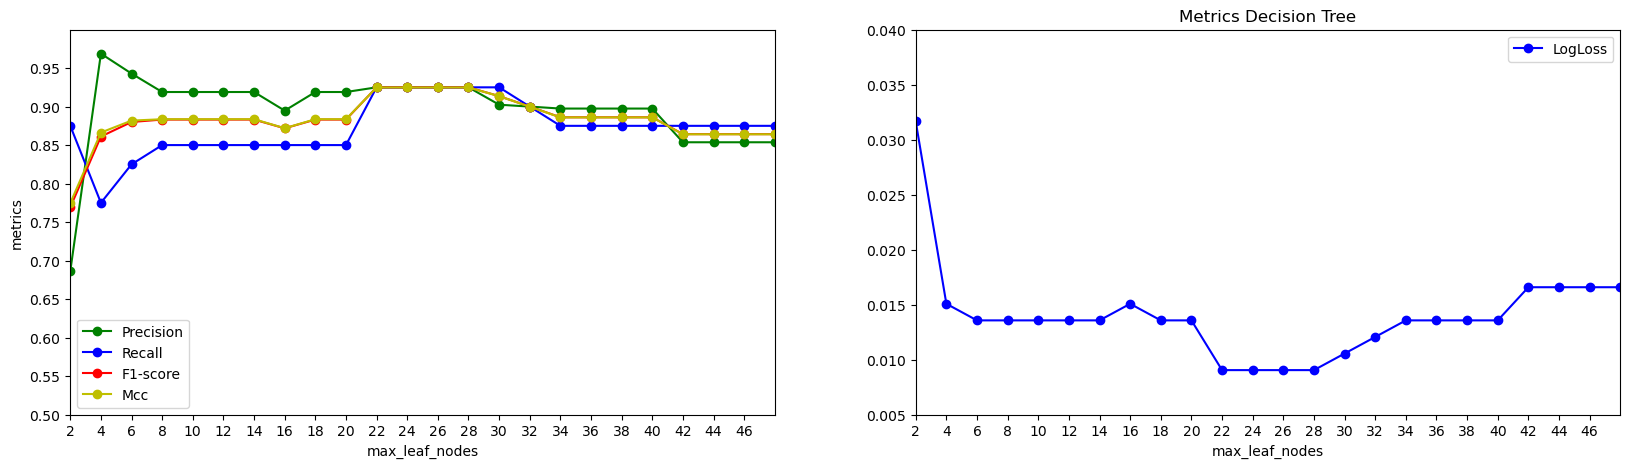

In [23]:
def test_leaf(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=1)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    description = "max_leaf_nodes : "+str(max_leaf_nodes)
    metrics = listmetrics(val_y, preds_val, "Decision Tree Classifier", description)
    return(metrics)


results = []
#for max_leaf_nodes in [3, 4, 5, 6, 7, 8, 9, 10]:
for max_leaf_nodes in np.arange(2, 50, 2, dtype=int):
    my_metrics_tree = test_leaf(max_leaf_nodes, OH_X_train, OH_X_valid, train_y, val_y)
    results.append(my_metrics_tree)
df = listmetricsintodf(results)
df.head()

graphmetrics(df, np.arange(2, 50, 2, dtype=int))

Entre le 22 et le 28 on a un bon pallié 
Va aussi regarder entre le 4 et 6

In [30]:
serie = [4, 5, 6, 7, 24]

res = []

for elem in serie :
    model = DecisionTreeClassifier(max_leaf_nodes= elem, random_state=1)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    model_test = model.predict(OH_X_test)
    description = "max_leaf_nodes : "+str(elem)+ " without date columns"
    metrics = listmetrics(val_y, preds_val, "Decision Tree Classifier", description)
    res.append(metrics)
    df = getscoreforcsv(index_val, model_test, name_file = "resultsfile"+str(elem)+".csv")
    print(f'File : resultsfile{elem}.csv')
    
df1 = listmetricsintodf(res)
df1["PublicScore"] = [0.6, 0.656249999, 0.666666666, 0.666666666, 0.644067796]
df1["PrivateScore"] = [0.566037735, 0.671875, 0.661016949, 0.661016949, 0.661157024]
df1["MeanOurMetrics"] = df1[['Precision', 'Recall','F1-score','Mcc']].mean(axis=1)
df1

done
File : resultsfile4.csv
done
File : resultsfile5.csv
done
File : resultsfile6.csv
done
File : resultsfile7.csv
done
File : resultsfile24.csv


,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc,PublicScore,PrivateScore,MeanOurMetrics
0,Decision Tree Classifier,max_leaf_nodes : 4 without date columns,2023-04-29 18:30:07.734818,0.968750,0.775,0.861111,0.015071,0.866284,0.600000,0.566038,0.867786
1,Decision Tree Classifier,max_leaf_nodes : 5 without date columns,2023-04-29 18:30:07.868025,0.871795,0.850,0.860759,0.016578,0.860598,0.656250,0.671875,0.860788
2,Decision Tree Classifier,max_leaf_nodes : 6 without date columns,2023-04-29 18:30:08.002271,0.942857,0.825,0.880000,0.013564,0.881780,0.666667,0.661017,0.882409
3,Decision Tree Classifier,max_leaf_nodes : 7 without date columns,2023-04-29 18:30:08.135530,0.918919,0.850,0.883117,0.013564,0.883602,0.666667,0.661017,0.883909
4,Decision Tree Classifier,max_leaf_nodes : 24 without date columns,2023-04-29 18:30:08.297146,0.925000,0.925,0.925000,0.009043,0.924874,0.644068,0.661157,0.924969


What is best for them is the 6 leaf, but it is not the best for us. 
### Random Forest 

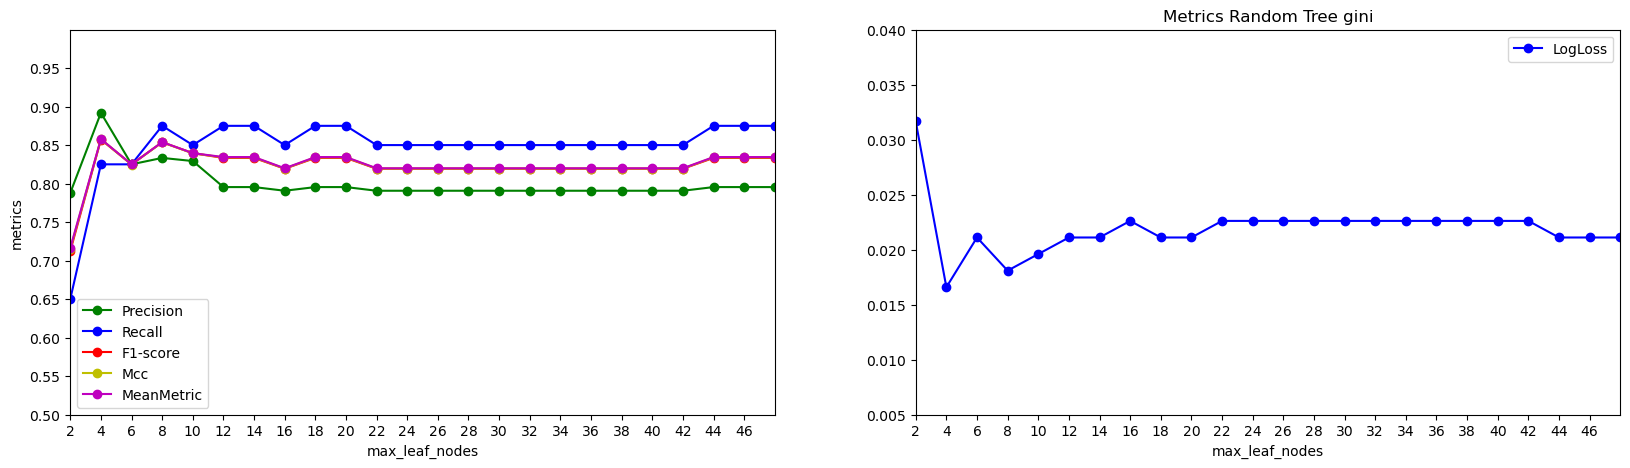

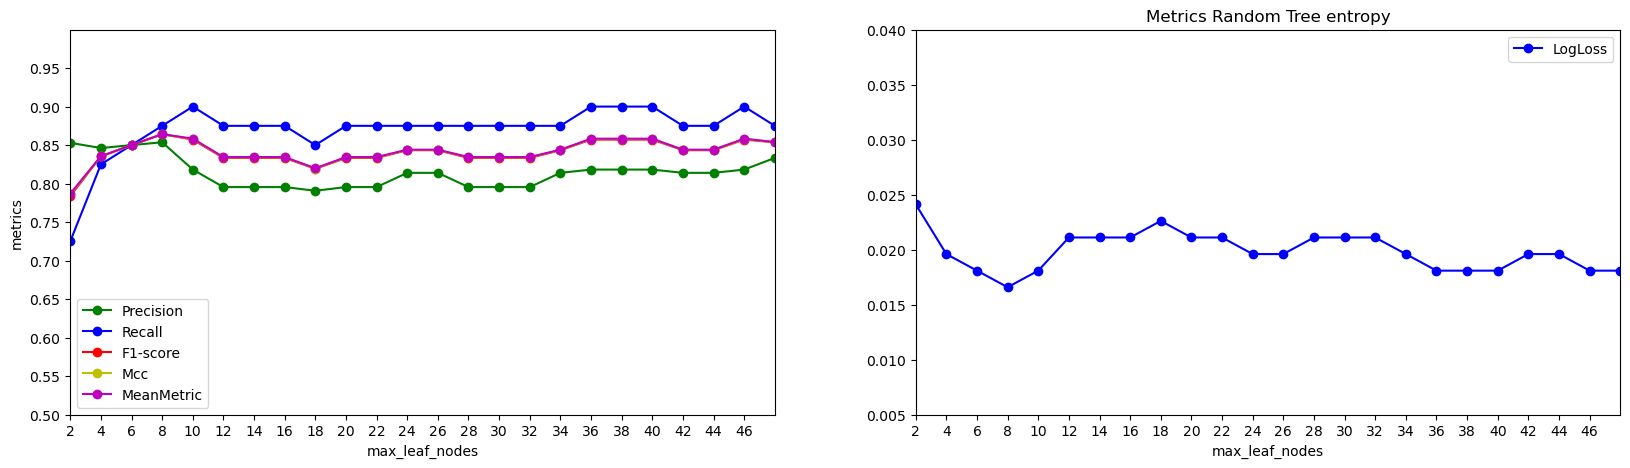

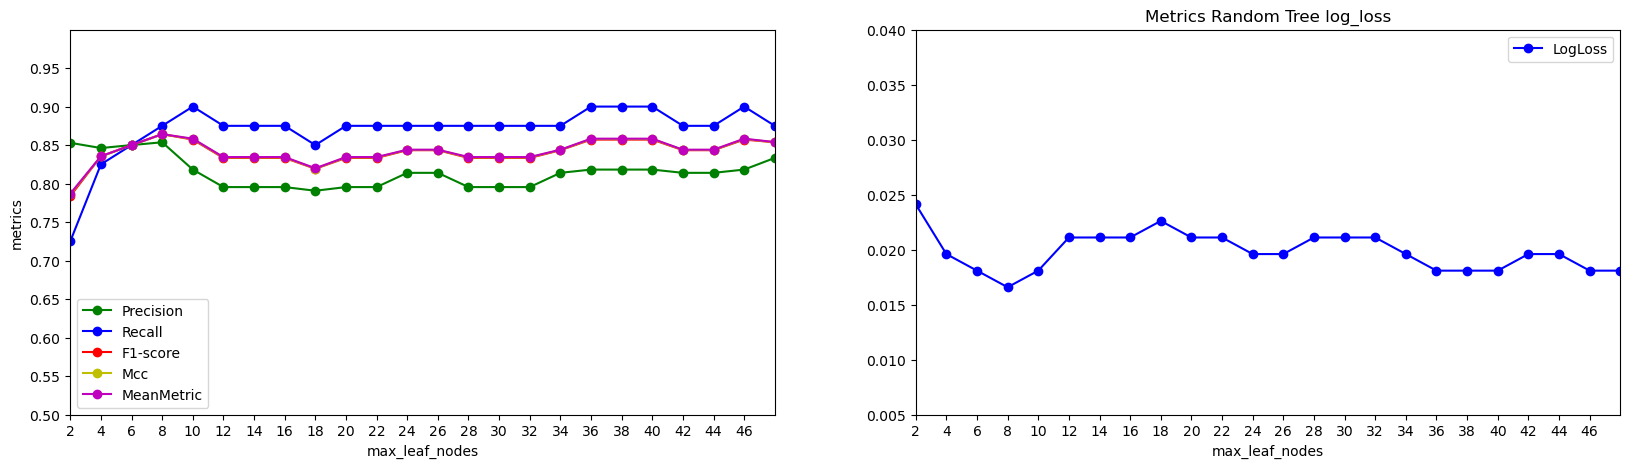

In [69]:
def test_random_forest(n_estimators, criterion, train_X, val_X, train_y, val_y):
    model = RandomForestClassifier(n_estimators=n_estimators, criterion = criterion, random_state=1)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    description = f'n_estimators : {n_estimators}, {criterion}'
    metrics = listmetrics(val_y, preds_val, "Random Forest Classifier", description)
    metrics.append(n_estimators)
    metrics.append(criterion)
    return(metrics)


results = []
for crit in ['gini', 'entropy', 'log_loss']:
    for trees in np.arange(2, 50, 2, dtype=int):
        my_metrics_Forest = test_random_forest(trees, crit, OH_X_train, OH_X_valid, train_y, val_y)
        results.append(my_metrics_Forest)
    df = pd.DataFrame(results, columns=['Model', 'Description', 'Date', 'Precision', 'Recall','F1-score','LogLoss','Mcc','PublicScore','PrivateScore', 'NEstimator', 'Criterion'])
df.head()
df["MeanOurMetrics"] = df[['Precision', 'Recall','F1-score','Mcc']].mean(axis=1)

for crit in ['gini', 'entropy', 'log_loss']:
    graphmetricsforest(df, np.arange(2, 50, 2, dtype=int), crit)

On voit que comparé au decision tree il est moins précis

In [61]:
df.sort_values(by=['MeanOurMetrics'], ascending = False).head(10) #Le top 10 

,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc,PublicScore,PrivateScore,NEstimator,Criterion,MeanOurMetrics
51,Random Forest Classifier,"n_estimators : 8, log_loss",2023-04-29 19:03:30.211962,0.853659,0.875,0.864198,0.016578,0.864033,NaN,NaN,8,log_loss,0.864222
27,Random Forest Classifier,"n_estimators : 8, entropy",2023-04-29 19:03:11.738838,0.853659,0.875,0.864198,0.016578,0.864033,NaN,NaN,8,entropy,0.864222
70,Random Forest Classifier,"n_estimators : 46, log_loss",2023-04-29 19:03:46.561707,0.818182,0.900,0.857143,0.018085,0.857869,NaN,NaN,46,log_loss,0.858298
28,Random Forest Classifier,"n_estimators : 10, entropy",2023-04-29 19:03:12.062516,0.818182,0.900,0.857143,0.018085,0.857869,NaN,NaN,10,entropy,0.858298
41,Random Forest Classifier,"n_estimators : 36, entropy",2023-04-29 19:03:21.668373,0.818182,0.900,0.857143,0.018085,0.857869,NaN,NaN,36,entropy,0.858298
67,Random Forest Classifier,"n_estimators : 40, log_loss",2023-04-29 19:03:42.537268,0.818182,0.900,0.857143,0.018085,0.857869,NaN,NaN,40,log_loss,0.858298
66,Random Forest Classifier,"n_estimators : 38, log_loss",2023-04-29 19:03:41.304766,0.818182,0.900,0.857143,0.018085,0.857869,NaN,NaN,38,log_loss,0.858298
65,Random Forest Classifier,"n_estimators : 36, log_loss",2023-04-29 19:03:40.161071,0.818182,0.900,0.857143,0.018085,0.857869,NaN,NaN,36,log_loss,0.858298
42,Random Forest Classifier,"n_estimators : 38, entropy",2023-04-29 19:03:22.826743,0.818182,0.900,0.857143,0.018085,0.857869,NaN,NaN,38,entropy,0.858298
43,Random Forest Classifier,"n_estimators : 40, entropy",2023-04-29 19:03:24.029252,0.818182,0.900,0.857143,0.018085,0.857869,NaN,NaN,40,entropy,0.858298


In [72]:
n_estimator = df.sort_values(by=['MeanOurMetrics'], ascending = False).NEstimator.head(10).values
criterions = df.sort_values(by=['MeanOurMetrics'], ascending = False).Criterion.head(10).values

res = []

for elem in np.arange(len(n_estimator)) :
    model = RandomForestClassifier(n_estimators=n_estimator[elem], criterion = criterions[elem], random_state=1)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    model_test = model.predict(OH_X_test)
    description = f'n_estimator : {n_estimator[elem]} criterion : {criterions[elem]} without date columns'
    metrics = listmetrics(val_y, preds_val, "Random Forest", description)
    res.append(metrics)
    getscoreforcsv(index_val, model_test, name_file = f'RandomForest_N{n_estimator[elem]}_C{criterions[elem]}.csv')
    print(f'File : RandomForest_N{n_estimator[elem]}_C{criterions[elem]}.csv')
    
df1 = listmetricsintodf(res)
df1["PublicScore"] = [0.627450980, 0.627450980, 0.690909090, 0.627450980, 0.690909090, 0.690909090, 0.690909090, 0.690909090, 0.690909090, 0.690909090]
df1["PrivateScore"] = [0.592592592, 0.592592592, 0.637168141, 0.584905660, 0.649122807, 0.649122807, 0.649122807, 0.649122807, 0.649122807, 0.649122807]
df1["MeanOurMetrics"] = df1[['Precision', 'Recall','F1-score','Mcc']].mean(axis=1)

done
File : RandomForest_N8_Clog_loss.csv
done
File : RandomForest_N8_Centropy.csv
done
File : RandomForest_N46_Clog_loss.csv
done
File : RandomForest_N10_Centropy.csv
done
File : RandomForest_N36_Centropy.csv
done
File : RandomForest_N40_Clog_loss.csv
done
File : RandomForest_N38_Clog_loss.csv
done
File : RandomForest_N36_Clog_loss.csv
done
File : RandomForest_N38_Centropy.csv
done
File : RandomForest_N40_Centropy.csv


,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc,PublicScore,PrivateScore,MeanOurMetrics
0,Random Forest,n_estimator : 8 criterion : log_loss without date columns,2023-04-29 19:28:38.990398,0.853659,0.875,0.864198,0.016578,0.864033,0.627451,0.592593,0.864222
1,Random Forest,n_estimator : 8 criterion : entropy without date columns,2023-04-29 19:28:39.340907,0.853659,0.875,0.864198,0.016578,0.864033,0.627451,0.592593,0.864222
2,Random Forest,n_estimator : 46 criterion : log_loss without date columns,2023-04-29 19:28:40.814917,0.818182,0.900,0.857143,0.018085,0.857869,0.690909,0.637168,0.858298
3,Random Forest,n_estimator : 10 criterion : entropy without date columns,2023-04-29 19:28:41.203127,0.818182,0.900,0.857143,0.018085,0.857869,0.627451,0.584906,0.858298
4,Random Forest,n_estimator : 36 criterion : entropy without date columns,2023-04-29 19:28:42.406577,0.818182,0.900,0.857143,0.018085,0.857869,0.690909,0.649123,0.858298
5,Random Forest,n_estimator : 40 criterion : log_loss without date columns,2023-04-29 19:28:43.778211,0.818182,0.900,0.857143,0.018085,0.857869,0.690909,0.649123,0.858298
6,Random Forest,n_estimator : 38 criterion : log_loss without date columns,2023-04-29 19:28:45.074191,0.818182,0.900,0.857143,0.018085,0.857869,0.690909,0.649123,0.858298
7,Random Forest,n_estimator : 36 criterion : log_loss without date columns,2023-04-29 19:28:46.300064,0.818182,0.900,0.857143,0.018085,0.857869,0.690909,0.649123,0.858298
8,Random Forest,n_estimator : 38 criterion : entropy without date columns,2023-04-29 19:28:47.597500,0.818182,0.900,0.857143,0.018085,0.857869,0.690909,0.649123,0.858298
9,Random Forest,n_estimator : 40 criterion : entropy without date columns,2023-04-29 19:28:48.975127,0.818182,0.900,0.857143,0.018085,0.857869,0.690909,0.649123,0.858298


In [73]:
df1.sort_values(by=['PublicScore','PrivateScore','MeanOurMetrics'], ascending = False)

,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc,PublicScore,PrivateScore,MeanOurMetrics
4,Random Forest,n_estimator : 36 criterion : entropy without date columns,2023-04-29 19:28:42.406577,0.818182,0.900,0.857143,0.018085,0.857869,0.690909,0.649123,0.858298
5,Random Forest,n_estimator : 40 criterion : log_loss without date columns,2023-04-29 19:28:43.778211,0.818182,0.900,0.857143,0.018085,0.857869,0.690909,0.649123,0.858298
6,Random Forest,n_estimator : 38 criterion : log_loss without date columns,2023-04-29 19:28:45.074191,0.818182,0.900,0.857143,0.018085,0.857869,0.690909,0.649123,0.858298
7,Random Forest,n_estimator : 36 criterion : log_loss without date columns,2023-04-29 19:28:46.300064,0.818182,0.900,0.857143,0.018085,0.857869,0.690909,0.649123,0.858298
8,Random Forest,n_estimator : 38 criterion : entropy without date columns,2023-04-29 19:28:47.597500,0.818182,0.900,0.857143,0.018085,0.857869,0.690909,0.649123,0.858298
9,Random Forest,n_estimator : 40 criterion : entropy without date columns,2023-04-29 19:28:48.975127,0.818182,0.900,0.857143,0.018085,0.857869,0.690909,0.649123,0.858298
2,Random Forest,n_estimator : 46 criterion : log_loss without date columns,2023-04-29 19:28:40.814917,0.818182,0.900,0.857143,0.018085,0.857869,0.690909,0.637168,0.858298
0,Random Forest,n_estimator : 8 criterion : log_loss without date columns,2023-04-29 19:28:38.990398,0.853659,0.875,0.864198,0.016578,0.864033,0.627451,0.592593,0.864222
1,Random Forest,n_estimator : 8 criterion : entropy without date columns,2023-04-29 19:28:39.340907,0.853659,0.875,0.864198,0.016578,0.864033,0.627451,0.592593,0.864222
3,Random Forest,n_estimator : 10 criterion : entropy without date columns,2023-04-29 19:28:41.203127,0.818182,0.900,0.857143,0.018085,0.857869,0.627451,0.584906,0.858298


On peut voir ici que l'algo gini est pas top, il vaut mieux utiliser l'entreopy ou log loss

In [50]:
def graphmetricsforest(df, rangelist, crit):
    x1 = df.loc[df.Criterion == crit].NEstimator.values
    y11 = df.loc[df.Criterion == crit].Precision.values
    y12 = df.loc[df.Criterion == crit].Recall.values
    y13 = df.loc[df.Criterion == crit]["F1-score"].values
    y14 = df.loc[df.Criterion == crit].LogLoss.values
    y15 = df.loc[df.Criterion == crit].Mcc.values
    y16 = df.loc[df.Criterion == crit].MeanOurMetrics.values
    
    
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    ax1.plot(x1, y11, 'g-o', label = "Precision")
    ax1.plot(x1, y12, 'b-o', label = "Recall")
    ax1.plot(x1, y13, 'r-o', label = "F1-score")
    ax2.plot(x1, y14, 'b-o', label = "LogLoss")
    ax1.plot(x1, y15, 'y-o', label = "Mcc")
    ax1.plot(x1, y16, 'm-o', label = "MeanMetric")
    plt.legend()


    ax2.set(xlim=(rangelist[0], rangelist[-1]), xticks=np.arange(rangelist[0], rangelist[-1], 2), ylim=(0.005, 0.04), yticks=np.arange(0.005, 0.04, 0.005), xlabel = "max_leaf_nodes")
    ax2.set_title('Log loss')
    ax1.set(xlim=(rangelist[0], rangelist[-1]), xticks=np.arange(rangelist[0], rangelist[-1], 2), ylim=(0.5, 1), yticks=np.arange(0.5, 1, 0.05), xlabel = "max_leaf_nodes", ylabel = "metrics")
    ax1.legend()

    plt.title("Metrics Random Tree "+crit)

    plt.legend()
    plt.show()

# XGBoost model  
Gradient boosting. Can take in acount the unbalanced data. 

The chose of scale_pos_weight to be tested.



In [4]:
# Set class weights
neg_res_tot = len(data[data.FraudResult==0])
pos_res_tot = len(data[data.FraudResult==1])


# Set "scale_pos_weight" based on class balance
pos_weight1 = neg_res_tot/pos_res_tot
pos_weight2 = sqrt(neg_res_tot/pos_res_tot)


weights = [pos_weight1, pos_weight2]
# A aussi regarder sur [15, 20, 22, 25, 30, 50] et donne la même chose

res = []
# Train XGBoost model
for w in weights:
    model = XGBClassifier(scale_pos_weight=w, random_state=1)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    model_test = model.predict(OH_X_test)
    description = "scale_pos_weight : "+str(w)+ " with date columns"
    metrics = listmetrics(val_y, preds_val, "XGBClassifier", description)
    res.append(metrics)
    df = getscoreforcsv(index_val, model_test, name_file = "XGBClassifierscale_pos_weight"+str(w)+".csv")
    print(f'File : resultsfile{w}.csv')
    
df1 = listmetricsintodf(res)
df1["PublicScore"] = [0.636363636,0.677419354]
df1["PrivateScore"] = [0.656716417, 0.676923076]
df1["MeanOurMetrics"] = df1[['Precision', 'Recall','F1-score','Mcc']].mean(axis=1)
df1

done
File : resultsfile494.6580310880829.csv
done
File : resultsfile22.240908953729452.csv


,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc,PublicScore,PrivateScore,MeanOurMetrics
0,XGBClassifier,scale_pos_weight : 494.6580310880829 with date columns,2023-05-06 18:02:05.702785,0.791667,0.950,0.863636,0.018085,0.866990,0.636364,0.656716,0.868073
1,XGBClassifier,scale_pos_weight : 22.240908953729452 with date columns,2023-05-06 18:02:07.189131,0.840909,0.925,0.880952,0.015071,0.881747,0.677419,0.676923,0.882152


Here we can see that it is better if the scale_pos_weight is lower. 

In [6]:
weights = [15, 20, 22, 25, 30, 50, 100, 200, 300, 500]

res = []
# Train XGBoost model
for w in weights:
    model = XGBClassifier(scale_pos_weight=w, random_state=1)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    model_test = model.predict(OH_X_test)
    description = "scale_pos_weight : "+str(w)+ " with date columns"
    metrics = listmetrics(val_y, preds_val, "XGBClassifier", description)
    res.append(metrics)
    #df = getscoreforcsv(index_val, model_test, name_file = "XGBClassifierscale_pos_weight"+str(w)+".csv")
    #print(f'File : resultsfile{w}.csv')
    
df1 = listmetricsintodf(res)
#df1["PublicScore"] = [0.636363636,0.677419354]
#df1["PrivateScore"] = [0.656716417, 0.676923076]
df1["MeanOurMetrics"] = df1[['Precision', 'Recall','F1-score','Mcc']].mean(axis=1)
df1

,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc,PublicScore,PrivateScore,MeanOurMetrics
0,XGBClassifier,scale_pos_weight : 15 with date columns,2023-05-06 18:11:50.370786,0.822222,0.925,0.870588,0.016578,0.871874,NaN,NaN,0.872421
1,XGBClassifier,scale_pos_weight : 20 with date columns,2023-05-06 18:11:51.762475,0.840909,0.925,0.880952,0.015071,0.881747,NaN,NaN,0.882152
2,XGBClassifier,scale_pos_weight : 22 with date columns,2023-05-06 18:11:53.130350,0.840909,0.925,0.880952,0.015071,0.881747,NaN,NaN,0.882152
3,XGBClassifier,scale_pos_weight : 25 with date columns,2023-05-06 18:11:54.470295,0.840909,0.925,0.880952,0.015071,0.881747,NaN,NaN,0.882152
4,XGBClassifier,scale_pos_weight : 30 with date columns,2023-05-06 18:11:55.813636,0.804348,0.925,0.860465,0.018085,0.862324,NaN,NaN,0.863034
5,XGBClassifier,scale_pos_weight : 50 with date columns,2023-05-06 18:11:57.175432,0.822222,0.925,0.870588,0.016578,0.871874,NaN,NaN,0.872421
6,XGBClassifier,scale_pos_weight : 100 with date columns,2023-05-06 18:11:58.668139,0.804348,0.925,0.860465,0.018085,0.862324,NaN,NaN,0.863034
7,XGBClassifier,scale_pos_weight : 200 with date columns,2023-05-06 18:12:00.127041,0.822222,0.925,0.870588,0.016578,0.871874,NaN,NaN,0.872421
8,XGBClassifier,scale_pos_weight : 300 with date columns,2023-05-06 18:12:01.603987,0.822222,0.925,0.870588,0.016578,0.871874,NaN,NaN,0.872421
9,XGBClassifier,scale_pos_weight : 500 with date columns,2023-05-06 18:12:03.135417,0.791667,0.950,0.863636,0.018085,0.866990,NaN,NaN,0.868073


# Oversample minority class

In [14]:
res = []
X_con = pd.concat([train_X, train_y], axis=1) 
not_fraud = X_con[X_con.FraudResult==0]
fraud = X_con[X_con.FraudResult==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=1) # reproducible results

upsampled = pd.concat([not_fraud, fraud_upsampled])

print(upsampled.FraudResult.value_counts())

train_y_over_sampled = upsampled.FraudResult
train_X_over_sampled = upsampled.drop('FraudResult', axis=1)

upsampledmodel = LogisticRegression(solver='liblinear').fit(train_X_over_sampled, train_y_over_sampled)
upsampled_pred = upsampledmodel.predict(val_X)
model_test = upsampledmodel.predict(OH_X_test)
description = "upsampled"
metrics = listmetrics(val_y, upsampled_pred, "LogisticRegression", description)
res.append(metrics)
df = getscoreforcsv(index_val, model_test, name_file = "LogisticRegression UpSample.csv")

upsampledmodel = RandomForestClassifier(n_estimators=36, criterion = 'entropy', random_state=1)
upsampledmodel.fit(train_X_over_sampled, train_y_over_sampled)
upsampled_pred = upsampledmodel.predict(val_X)
model_test = upsampledmodel.predict(OH_X_test)
description = "upsampled, n_estimators=36, criterion = entropy"
metrics = listmetrics(val_y, upsampled_pred, "RandomForestClassifier", description)
res.append(metrics)
df = getscoreforcsv(index_val, model_test, name_file = "RandomForestClassifier UpSample.csv")


df1 = listmetricsintodf(res)
df1["PublicScore"] = [0.142450142,0.678571428]
df1["PrivateScore"] = [0.151603498, 0.637168141]
df1["MeanOurMetrics"] = df1[['Precision', 'Recall','F1-score','Mcc']].mean(axis=1)
df1

0    71593
1    71593
Name: FraudResult, dtype: int64


C:\Users\sarah\anaconda3\envs\AILab-ECAM4\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


done
done


,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc,PublicScore,PrivateScore,MeanOurMetrics
0,LogisticRegression,upsampled,2023-05-06 18:36:59.884831,0.121118,0.975,0.215470,0.428015,0.341487,0.142450,0.151603,0.413269
1,RandomForestClassifier,"upsampled, n_estimators=36, criterion = entropy",2023-05-06 18:37:02.209737,0.765957,0.900,0.827586,0.022606,0.829975,0.678571,0.637168,0.830880


In [15]:
upsampled[upsampled.FraudResult ==1].head()

,Amount,Value,Day,Hour,week_day,weeks,BatchId,AccountId,SubscriptionId,CustomerId,...,14,15,16,17,18,19,20,21,22,FraudResult
TransactionId,,,,,,,,,,,,,,,,,,,,,
76982,530000.0,530000.0,4,14,0,2,32000,4004,380,4454,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
49913,2000000.0,2000000.0,28,21,0,5,133354,1240,4672,1602,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
23427,100000.0,100000.0,24,15,3,4,4345,1609,2872,1988,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
33086,500000.0,500000.0,12,21,1,3,40160,1909,2496,2303,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
135575,500000.0,500000.0,2,12,2,1,31165,2289,3706,2703,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1


The logistic regression is super bad but why ?

In [16]:
# pour le dataset en entier 
res = []
Xcompl = pd.concat([train_X, val_X])
ycompl = pd.concat([train_y, val_y])
X_con = pd.concat([Xcompl, ycompl], axis=1) 
not_fraud = X_con[X_con.FraudResult==0]
fraud = X_con[X_con.FraudResult==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=1) # reproducible results

upsampled = pd.concat([not_fraud, fraud_upsampled])

print(upsampled.FraudResult.value_counts())

train_y_over_sampled = upsampled.FraudResult
train_X_over_sampled = upsampled.drop('FraudResult', axis=1)

upsampledmodel = LogisticRegression(solver='liblinear').fit(train_X_over_sampled, train_y_over_sampled)
model_test = upsampledmodel.predict(OH_X_test)
description = "upsampled"
df = getscoreforcsv(index_val, model_test, name_file = "LogisticRegression UpSample set complet.csv")

upsampledmodel = RandomForestClassifier(n_estimators=36, criterion = 'entropy', random_state=1)
upsampledmodel.fit(train_X_over_sampled, train_y_over_sampled)
model_test = upsampledmodel.predict(OH_X_test)
df = getscoreforcsv(index_val, model_test, name_file = "RandomForestClassifier UpSample set complet.csv")

# the result are worst !! 
# 0.54 for Random Forest an 0.1 for Logisitic regression

0    95469
1    95469
Name: FraudResult, dtype: int64
done
done


# Under Sample

In [18]:
res = []
X_con = pd.concat([train_X, train_y], axis=1) 
not_fraud = X_con[X_con.FraudResult==0]
fraud = X_con[X_con.FraudResult==1]

# upsample minority
not_fraud_downsampled  = resample(not_fraud,
                          replace=False, # sample without replacement
                          n_samples=len(fraud), # match number in minority  class
                          random_state=1) # reproducible results

downsampled  = pd.concat([not_fraud_downsampled , fraud])

print(downsampled.FraudResult.value_counts())

train_y_undersampled = downsampled.FraudResult
train_X_undersampled = downsampled.drop('FraudResult', axis=1)

undersampled  = LogisticRegression(solver='liblinear').fit(train_X_undersampled, train_y_undersampled)
undersampled_pred  = undersampled.predict(val_X)
model_test = undersampled.predict(OH_X_test)
description = "undersampled"
metrics = listmetrics(val_y, undersampled_pred, "LogisticRegression", description)
res.append(metrics)
df = getscoreforcsv(index_val, model_test, name_file = "LogisticRegression undersampled.csv")

undersampled = RandomForestClassifier(n_estimators=36, criterion = 'entropy', random_state=1)
undersampled.fit(train_X_over_sampled, train_y_over_sampled)
undersampled_pred = undersampled.predict(val_X)
model_test = undersampled.predict(OH_X_test)
description = "undersampled, n_estimators=36, criterion = entropy"
metrics = listmetrics(val_y, undersampled_pred, "RandomForestClassifier", description)
res.append(metrics)
df = getscoreforcsv(index_val, model_test, name_file = "RandomForestClassifier undersampled.csv")


df1 = listmetricsintodf(res)
df1["PublicScore"] = [0.125944584, 0.549019607]
df1["PrivateScore"] = [0.129192546, 0.480769230]
df1["MeanOurMetrics"] = df1[['Precision', 'Recall','F1-score','Mcc']].mean(axis=1)
df1
#ici on a un cas de overfitting!!!!

0    153
1    153
Name: FraudResult, dtype: int64
done
done


,Model,Description,Date,Precision,Recall,F1-score,LogLoss,Mcc,PublicScore,PrivateScore,MeanOurMetrics
0,LogisticRegression,undersampled,2023-05-06 19:03:52.313000,0.130435,0.975,0.230088,3.933515e-01,0.35456,0.125945,0.129193,0.422521
1,RandomForestClassifier,"undersampled, n_estimators=36, criterion = entropy",2023-05-06 19:03:55.455399,1.000000,1.000,1.000000,2.220446e-16,1.00000,0.549020,0.480769,1.000000
